# **Projet Python : prévision de la production éléctrique éolienne en France**
#### Florian Basso, Théo Ferry, Julien Peignon
***
L'objectif de ce projet est d'utiliser des données météorologiques de vents ainsi que des données liées au parc éolien français (position des éoliennes, puissance potentielle, etc..) afin de mettre en place des modèles de prédiction de la production d'énergie éolienne.
***
## 1) Données
### a) Récupération
Les données du Ministère de la Transition Écologique et de RTE sont en open data. Les données de Météo France sur les vents sont disponibles avec une API.

**Code à venir:** API données métérologiques, code téléchargement données éoliennes + données RTE

In [31]:
#Importation des librairies


!pip install pandas fiona shapely pyproj rtree  #Sur colab, sinon bug
# A faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales

!pip install contextily
!pip install geopandas
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug

from shapely.geometry import Point


import json
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import pytz

from cartiflette.download import get_vectorfile_ign


  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.
anaconda-client 1.11.0 requires urllib3>=1.26.4, but you have urllib3 1.22 which is incompatible.
aiobotocore 2.4.0 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.23.26 which is incompatible.
  Using cached botocore-1.27.59-py3-n

ImportError: cannot import name 'apply_request_checksum' from 'botocore.client' (/Users/lucius/opt/anaconda3/lib/python3.9/site-packages/botocore/client.py)

#### **1.** Récupération de l'historique la production d'électricité éolienne depuis 2015 - API RTE

Le but de ces premières lignes de code est de récupérer l'historique de la production d'électricité éolienne depuis 2015. On récupère ces données en passant par l'API de Réseau de Transport d'Electricité (RTE),le gestionnaire de réseau de transport français responsable du réseau public de transport d'électricité haute tension en France métropolitaine. 

L'API utilise une authentification Oauth 2.0 et nous avons du créer un compte et justifier notre démarche auprès de RTE pour obtenir des identifiants permettant de faire des requêtes à l'API. L'accès à l'API se fait par le protocole REST.


In [33]:
#Identifiants compte RTE (à ne pas diffuser)
client_id = "ac96732a-51ba-4487-91ee-755f22119c52"
client_secret = "12640de5-1bdf-411e-bc9d-905776c3557e"
url = "https://digital.iservices.rte-france.com/token/oauth/"


In [34]:
def get_access_token(url, client_id, client_secret):
    response = requests.post(
        url,
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )
    return response.json()["access_token"]


myToken = get_access_token(url, client_id, client_secret)

L'API RTE impose une limite sur la taille des données envoyées aux utilisateurs. Afin de contourner ce problème, on construit une boucle pour faire des requêtes sur l'API et append les résultats des requêtes à un dataframe.

Que le lecteur soit ici rassuré, elle ne prend que deux modestes minutes (peut-être encore moins sur les belles machines républicaines de l'INSEE) pour tourner.

In [35]:
#On définit plusieurs fonctions pour simplifier les conditions sur le code et rendre plus rapide son exécution

#fonction pour écrire les mois avec 0
def f(x):
    if len(x)<2:
        x = "0" + x
    return x

#fonction pour retourner les mois de débuts et de fin des échantillons que l'on souhaite
def caract(deb_mois,deb_annees):
    fin_annees = deb_annees
    deb_mois = f(deb_mois)
    fin_mois = str(int(deb_mois)+1)
    fin_mois=f(fin_mois)
    if int(fin_mois)>12: # Janvier de l'année d'après
        fin_mois = "01"
        fin_annees=str(int(deb_annees)+1)
    return deb_mois, deb_annees, fin_mois, fin_annees

base_url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/actual_generations_per_production_type?"

#on crée un dataframe vide auquel on va append les données RTE 
df1 = pd.DataFrame(columns = ['start_date', 'end_date', 'value'])

for i in range(2015,2023): 
    for j in range(1,13):
        #boucle sur les dates

        deb_mois = str(j)
        deb_annees = str(i)
        deb_mois,deb_annees, fin_mois, fin_annees = caract(deb_mois, deb_annees)
        
        #On brise la boucle pour le mois de décembre 2022 (données non disponibles)
        if deb_mois == "12" and deb_annees=="2022" :
            break
        

        #configuration URL API

        start_date = deb_annees + "-" + deb_mois + "-01T00:00:00%2B02:00"
        end_date = fin_annees + '-' + fin_mois + "-01T00:00:00%2B02:00" 
        complete_url = base_url + "start_date=" + start_date + "&end_date=" + end_date 

        #authentification

        head = {'Authorization': 'Bearer {}'.format(myToken)}
        response = requests.get(complete_url, headers=head)

        #formatage des données; de JSON à un dataframe
        json2 = response.json()
        df_rte = pd.json_normalize(json2['actual_generations_per_production_type'][10], 'values')
        df_rte['end_date'] = pd.to_datetime(df_rte['end_date'])
        df_rte['start_date'] = pd.to_datetime(df_rte['start_date'])

        #on merge les dataframes par les lignes
        df1 = [df1, df_rte]
        df1 = pd.concat(df1)



df1.head()

,start_date,end_date,value,updated_date
0,2015-01-01 00:00:00+01:00,2015-01-01 01:00:00+01:00,1314,NaN
1,2015-01-01 01:00:00+01:00,2015-01-01 02:00:00+01:00,1383,NaN
2,2015-01-01 02:00:00+01:00,2015-01-01 03:00:00+01:00,1464,NaN
3,2015-01-01 03:00:00+01:00,2015-01-01 04:00:00+01:00,1543,NaN
4,2015-01-01 04:00:00+01:00,2015-01-01 05:00:00+01:00,1579,NaN


On nettoie rapidement notre dataframe pour ne garder que les variables d'intérêt.

In [41]:
df1 = df1.drop(columns =['start_date', 'updated_date'])
df1

KeyError: "['start_date', 'updated_date'] not found in axis"

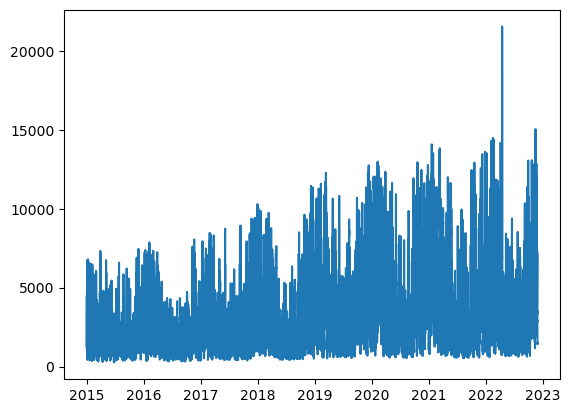

In [42]:
len(df1)
plt.plot(df1['end_date'],df1['value'])


On transforme les dates qui étaient de type "string" en date, pour ce faire on les convertit avec le fuseau horaire universel.


In [43]:
#ici on convertit les dates au format UTC pour pouvoir les convertir au format date
#Cela n'aura pas d'incidence sur les moyennes mensuelles et annuelles.
df1['end_date'] = pd.to_datetime(df1['end_date'], utc=True)


In [44]:
#On les met au 
df1 = df1.set_index('end_date')
df1.head()



,value
end_date,
2015-01-01 00:00:00+00:00,1314
2015-01-01 01:00:00+00:00,1383
2015-01-01 02:00:00+00:00,1464
2015-01-01 03:00:00+00:00,1543
2015-01-01 04:00:00+00:00,1579


<AxesSubplot:xlabel='end_date'>

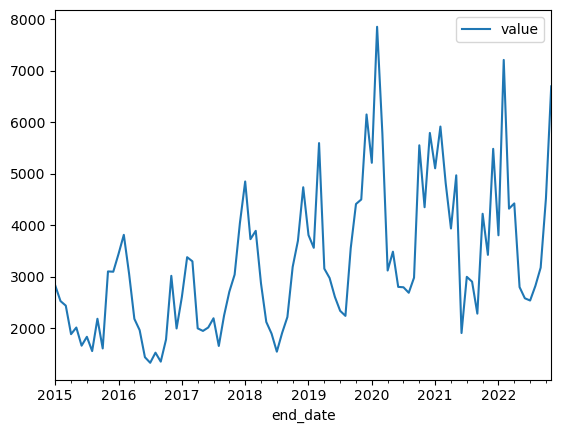

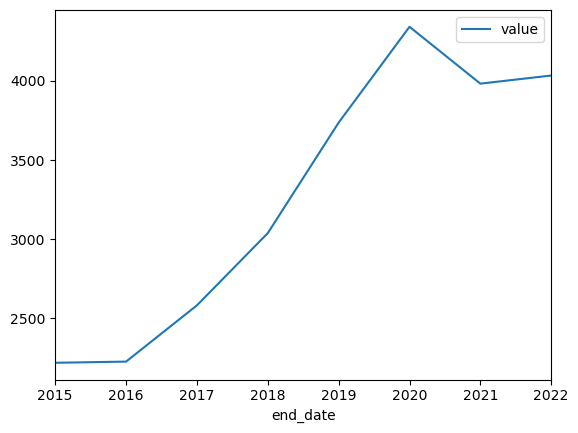

In [45]:
#On obtient les graphiques de moyennes mensuelles et annuelles
df1.resample('M').mean().plot()
df1.resample('Y').mean().plot()

Ces graphiques indiquent la moyenne horaire de production de la filière éolienne par mois et par an. 

On constate ici que la production électrique moyenne mensuelle a contunuellement cru (abstraction faite de la périodicité des vents) de 2015 à 2020, année remarquablement ventée comme on le verra par la suite.
Les faibles vents de 2021, malgré la croissance du parc éolien français, sont à l'origine de la baisse de la production d'électricité éolienne .

In [11]:




#je laisse start et end mais bien garder en tête l'intervalle de temps

#Ce qu'il reste à faire :
#afficher la série temp et variations infra/semaines/mois/saisons

#intermittence du vent et de l'énergie 

#### Pour faire notre travail nous avons également besoin de données sur les vents

Nous donnons un exemple d'utilisation de l'API pour récupérer les données de vent à une latitude/longitude et date données.

In [13]:
base_url = "https://archive-api.open-meteo.com/v1/era5?"
latitude=str(52.52)
longitude=str(13.41)
start_date="2022-06-08"
end_date="2022-12-04"
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date

reponse = requests.get(complete_url)
print(reponse.content)

b'{"latitude":52.5,"longitude":13.5,"generationtime_ms":0.44608116149902344,"utc_offset_seconds":0,"timezone":"GMT","timezone_abbreviation":"GMT","elevation":49.0,"hourly_units":{"time":"iso8601","windspeed_10m":"m/s"},"hourly":{"time":["2022-06-08T00:00","2022-06-08T01:00","2022-06-08T02:00","2022-06-08T03:00","2022-06-08T04:00","2022-06-08T05:00","2022-06-08T06:00","2022-06-08T07:00","2022-06-08T08:00","2022-06-08T09:00","2022-06-08T10:00","2022-06-08T11:00","2022-06-08T12:00","2022-06-08T13:00","2022-06-08T14:00","2022-06-08T15:00","2022-06-08T16:00","2022-06-08T17:00","2022-06-08T18:00","2022-06-08T19:00","2022-06-08T20:00","2022-06-08T21:00","2022-06-08T22:00","2022-06-08T23:00","2022-06-09T00:00","2022-06-09T01:00","2022-06-09T02:00","2022-06-09T03:00","2022-06-09T04:00","2022-06-09T05:00","2022-06-09T06:00","2022-06-09T07:00","2022-06-09T08:00","2022-06-09T09:00","2022-06-09T10:00","2022-06-09T11:00","2022-06-09T12:00","2022-06-09T13:00","2022-06-09T14:00","2022-06-09T15:00","20

### **a) Un exemple simple**

Maintenant que nous avons montré comment fonctionnait l'API, nous montrons comment nous allons nous servir de ces données météorologiques en prenant l'exemple de la première éoliennes de notre base de données. 

Ainsi, dans un premier temps, nous récupérons les données de vent pour cette éolienne précisément.

## **1) Les données sur les éoliennes**
### **a) Travail introductif sur la base de données**

Dans un premier temps, nous souhaitons décrire la répartition du parc éolien sur le territoire national (métropole seulement). Pour ce faire, nous allons créer une carte de la France et y afficher la position des éoliennes. 

On télécharge les données du Ministère de la Transition Ecologique et de la Cohésion des Territoires.

(https://www.georisques.gouv.fr/donnees/bases-de-donnees/eolien-terrestre)

In [14]:
import pandas as pd
df = pd.read_csv("eolien.csv", sep=";")

In [15]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaN,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


Ces données décrivent la position ainsi que certaines caractéristiques des éoliennes. Parmi ces caractérisques, celles qui nous intéressent dans notre objectif de prédiction de la production sont : la longueur des pales et le diamètre du rotor. La position des éoliennes nous permettra quant à elle d'associer chaque éolienne au vent auquel elle fait face. Dans la production d'énergie éolienne, le vent est évidemment la variable explicative la plus importante.

On convertit la colonne date_mise_en_service afin d'avoir des dates dans un format plus facilement interprétable.

In [16]:
import datetime

df.date_mise_en_service = pd.to_datetime((df.date_mise_en_service))

#### Rapide exploration des données et nettoyage

Certaines éoliennes de ce tableau ne sont pas encore en service.

In [17]:
df[df.date_mise_en_service > datetime.datetime.now()].count()

id_aerogenerateur        11
id_parc                  11
code_insee               11
nom_commune              11
code_dept                11
code_reg                 11
puissance                11
hauteur_totale           11
hauteur_mat_nacelle      11
diametre_rotor           11
cote_ngf                 11
periode_allumage_lib     11
periode_allumage_desc     0
type_feu_lib             11
type_feu_desc             0
date_mise_en_service     11
constructeur             11
reference_modele         11
x_aerogenerateur         11
y_aerogenerateur         11
epsg                     11
libelle                  11
date_maj                 11
nom_eolienne              0
dtype: int64

On voit qu'il n'y a que 11 éoliennes qui ne sont pas encore installées.
On les supprime de notre étude. 

In [18]:
df = df[df.date_mise_en_service.isna() | (df.date_mise_en_service < datetime.datetime.now())]

In [19]:
df['date_mise_en_service'].head()

0   2011-04-23
1   2014-04-01
2   2014-04-01
3   2014-04-01
4          NaT
Name: date_mise_en_service, dtype: datetime64[ns]

In [20]:
df.count()

id_aerogenerateur        7472
id_parc                  7472
code_insee               7472
nom_commune              7472
code_dept                7472
code_reg                 7472
puissance                7472
hauteur_totale           7472
hauteur_mat_nacelle      7472
diametre_rotor           7472
cote_ngf                 7472
periode_allumage_lib     7472
periode_allumage_desc       0
type_feu_lib             7472
type_feu_desc               0
date_mise_en_service     4320
constructeur             7472
reference_modele         7472
x_aerogenerateur         7472
y_aerogenerateur         7472
epsg                     7472
libelle                  7472
date_maj                 7472
nom_eolienne              347
dtype: int64

La variable 'puissance' indique la puissance installée en MégaWatt d'une éolienne, c'est la puissance maximale que celle-ci peut fournir. Les éoliennes les plus puissantes en France peuvent fournir aux alentours de 13MW. On constate que certaines observations ont des valeurs aberrantes pour la variable 'puissance', on les retire de notre échantillon.

In [21]:
df[df.puissance > 15].count()

id_aerogenerateur        18
id_parc                  18
code_insee               18
nom_commune              18
code_dept                18
code_reg                 18
puissance                18
hauteur_totale           18
hauteur_mat_nacelle      18
diametre_rotor           18
cote_ngf                 18
periode_allumage_lib     18
periode_allumage_desc     0
type_feu_lib             18
type_feu_desc             0
date_mise_en_service      8
constructeur             18
reference_modele         18
x_aerogenerateur         18
y_aerogenerateur         18
epsg                     18
libelle                  18
date_maj                 18
nom_eolienne              1
dtype: int64

In [22]:
df = df[df.puissance.isna() | (df.puissance < 15)]

In [30]:
df.count()

id_aerogenerateur        7454
id_parc                  7454
code_insee               7454
nom_commune              7454
code_dept                7454
code_reg                 7454
puissance                7454
hauteur_totale           7454
hauteur_mat_nacelle      7454
diametre_rotor           7454
cote_ngf                 7454
periode_allumage_lib     7454
periode_allumage_desc       0
type_feu_lib             7454
type_feu_desc               0
date_mise_en_service     4312
constructeur             7454
reference_modele         7454
x_aerogenerateur         7454
y_aerogenerateur         7454
epsg                     7454
libelle                  7454
date_maj                 7454
nom_eolienne              346
geometry                 7454
dtype: int64

Nos données décrivent 7454 éoliennes. Néanmoins, la date de mise en service n'est précisée que pour 4312 d'entre elles. Cela représente 58% de la base de données. 

Désormais, nous allons réaliser ces étapes pour chacune de nos éoliennes.

Nous convertissons nos données afin qu'elles soient exploitables par geopandas

On crée la variable geometry qui nous permettra de manipuler la position des éoliennes plus simplement.

In [27]:
geometrie = [Point(xy) for xy in zip(df.x_aerogenerateur,df.y_aerogenerateur)] # colonnes du DataFrame résultants
caract_eoliennes = gpd.GeoDataFrame(df,geometry=geometrie)
caract_eoliennes = caract_eoliennes.set_crs(2154, allow_override=True)

In [28]:
caract_eoliennes.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne,geometry
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN,POINT (371155.000 6786614.000)
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN,POINT (395860.280 6887806.500)
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN,POINT (395830.440 6886987.000)
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN,POINT (395760.560 6886064.000)
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN,POINT (463180.000 6547301.000)


In [25]:
#Le code est long à tourner et les données sont déjà fournies!

import csv

caract_eoliennes = caract_eoliennes.to_crs(4326)

base_url = "https://archive-api.open-meteo.com/v1/era5?"

end_date="2021-01-02"
end_date_comparaison = pd.to_datetime(end_date)
fichier_csv = open(r'C:\Users\theof\Desktop\ProjetPython\donnees_vent.csv','w',newline='')

writer = csv.writer(fichier_csv)

for eolienne in caract_eoliennes.itertuples():
    a = eolienne.geometry
    longitude=str(a.x)
    latitude=str(a.y)
    date = pd.to_datetime(eolienne.date_mise_en_service).date()
    if pd.isnull(date):
        start_date = "2021-01-01" 
    elif date < end_date_comparaison:
        start_date=str(max(date, pd.to_datetime("2021-01-01").date()))
        complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date
        reponse = requests.get(complete_url)
        donnees_vent_eolienne = pd.DataFrame(reponse.json())['hourly']
        writer.writerow([eolienne.Index,donnees_vent_eolienne['time'],donnees_vent_eolienne['windspeed_10m']])
    if eolienne.Index%50 == 0 : 
            print(eolienne.Index)


NameError: name 'caract_eoliennes' is not defined

Ici on réalise le même code que précédemment mais pour obtenir la météo prédite 

In [35]:
#Le code est long à tourner

import csv

caract_eoliennes = caract_eoliennes.to_crs(4326)

base_url = "https://api.open-meteo.com/v1/forecast?"

end_date_comparaison = pd.to_datetime(end_date)
fichier_csv = open(r'C:\Users\theof\Desktop\ProjetPython\donnees_vent_prediction.csv','w',newline='')

writer = csv.writer(fichier_csv)


start_date = "2022-12-13"

end_date = "2022-12-15"


for eolienne in caract_eoliennes.itertuples():
    a = eolienne.geometry
    longitude=str(a.x)
    latitude=str(a.y)
    date = pd.to_datetime(eolienne.date_mise_en_service).date()
    complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date
    reponse = requests.get(complete_url)
    donnees_vent_eolienne = pd.DataFrame(reponse.json())['hourly']
    writer.writerow([eolienne.Index,donnees_vent_eolienne['time'],donnees_vent_eolienne['windspeed_10m']])
    if eolienne.Index%50 == 0 : 
            print(eolienne.Index)

0
50


KeyboardInterrupt: 

In [24]:
caract_eoliennes = caract_eoliennes.to_crs(4326)

NameError: name 'caract_eoliennes' is not defined

In [70]:
a = caract_eoliennes.geometry[0]
print(a)
print(a.x)

POINT (-1.419713547794628 48.09705051237692)
-1.4197135477946279


In [71]:
latitude=str(a.y)
longitude=str(a.x)
start_date=str(pd.to_datetime(caract_eoliennes.date_mise_en_service[0]).date())
print(start_date)
end_date="2022-12-04"

2011-04-23


In [72]:
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date


import json
json.rep = requests.get(complete_url).json()

In [73]:
donnees_vent = pd.DataFrame(json.rep['hourly'])

donnees_vent['time'] = pd.to_datetime(donnees_vent['time'])
donnees_vent = donnees_vent.set_index('time')

donnees_vent.head()

,windspeed_10m
time,
2011-04-23 00:00:00,2.34
2011-04-23 01:00:00,2.33
2011-04-23 02:00:00,1.80
2011-04-23 03:00:00,1.84
2011-04-23 04:00:00,1.70


Pour cette éolienne, nous traçons la série temporelle du vent (vitesse moyenne sur 10mn heure par heure).

<AxesSubplot:xlabel='time'>

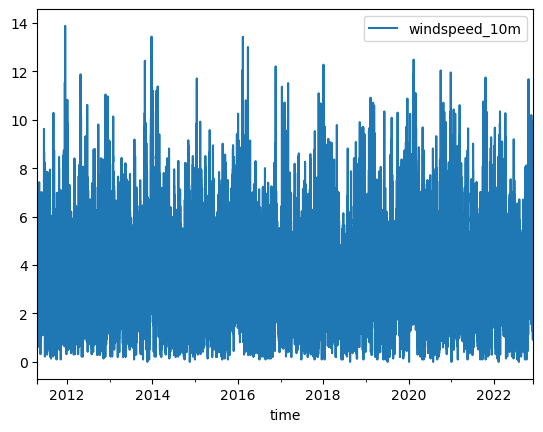

In [34]:
donnees_vent.plot()

On affiche également les moyennes de vent par an et par mois.

<AxesSubplot:xlabel='time'>

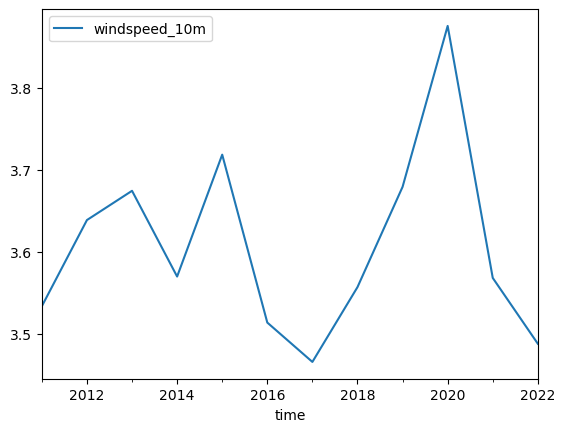

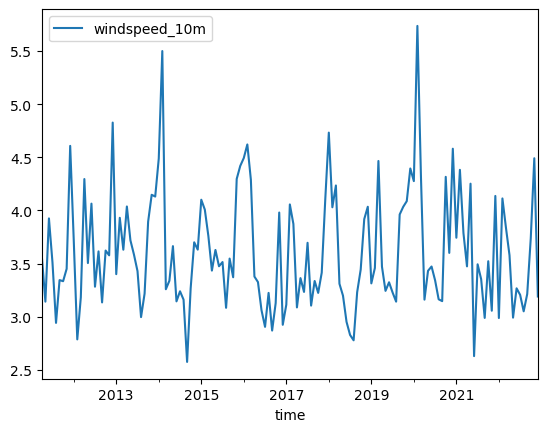

In [74]:
donnees_vent.resample('Y').mean().plot()
donnees_vent.resample('M').mean().plot()


Afin de calculer la production éléctrique (estimée) d'une éolienne à partir du vent qu'elle reçoit nous avons besoin de quelques notions de physique. 

La puissance d'une éolienne est donnée par $P = 1/2 \rho S V^3$ où $V$ est la vitesse du vent et $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 
Nous avons accès dans nos données à la longueur des pâles des éoliennes donc nous pouvons retrouver la puissance de l'éolienne.
L'énergie fournie sur une heure est donc cette puissance multipliée par le temps. Pour une éolienne, on peut considérer un facteur de charge de 16/27 (limite de Betz). Nous allons le prendre en compte pour calculer l'énergie fournie par une éolienne. 
Nous pourrions aller plus loin en prenant en compte la température et la pression qui influent sur la masse volumique de l'air $\rho$ et peuvent conduire à une variation de l'ordre de 20%.
Il serait également intéressant de regarder à la moyenne du vent par mois.

Nous créons une fonction qui calcule l'énergie produite (estimée) et nous affichons la série temporelle de cette énergie produite pour l'éolienne considérée dans cette exemple.

In [75]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * longueur_pale**2 * np.power(vitesse_vent,3)

In [76]:
diametre_rotor = caract_eoliennes['diametre_rotor'][0]
longueur_pale = caract_eoliennes['hauteur_totale'][0] - caract_eoliennes['hauteur_mat_nacelle'][0] # Je crois (Julien)

In [77]:
donnees_vent['energie'] = calcul_energie(diametre_rotor,donnees_vent['windspeed_10m'])

In [78]:
donnees_vent.index

DatetimeIndex(['2011-04-23 00:00:00', '2011-04-23 01:00:00',
               '2011-04-23 02:00:00', '2011-04-23 03:00:00',
               '2011-04-23 04:00:00', '2011-04-23 05:00:00',
               '2011-04-23 06:00:00', '2011-04-23 07:00:00',
               '2011-04-23 08:00:00', '2011-04-23 09:00:00',
               ...
               '2022-12-04 14:00:00', '2022-12-04 15:00:00',
               '2022-12-04 16:00:00', '2022-12-04 17:00:00',
               '2022-12-04 18:00:00', '2022-12-04 19:00:00',
               '2022-12-04 20:00:00', '2022-12-04 21:00:00',
               '2022-12-04 22:00:00', '2022-12-04 23:00:00'],
              dtype='datetime64[ns]', name='time', length=101856, freq=None)

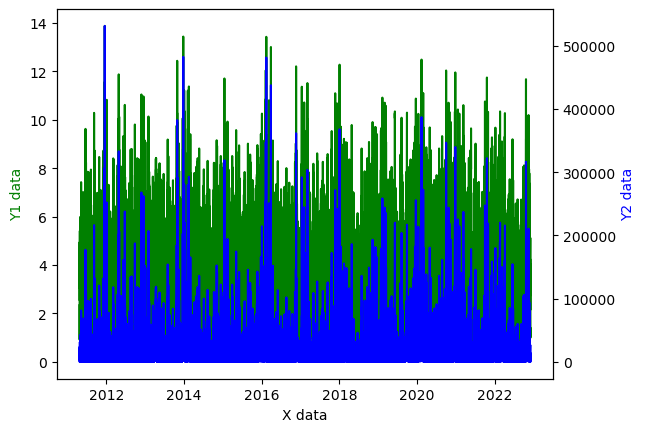

<AxesSubplot:xlabel='time'>

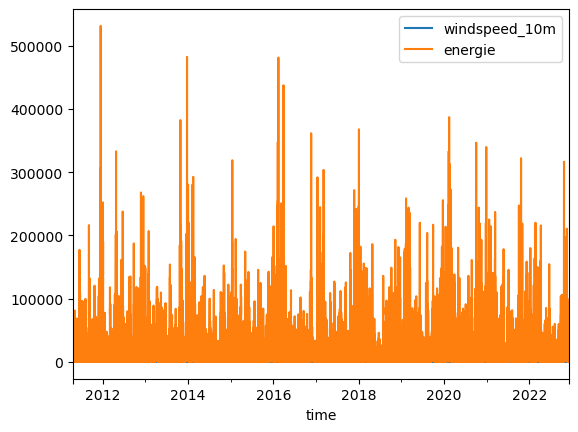

In [79]:
#Faire un graphique avec deux axes et deux échelles
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(donnees_vent.index, donnees_vent['windspeed_10m'], 'g-')
ax2.plot(donnees_vent.index, donnees_vent['energie'], 'b-')

ax1.set_xlabel('Années')
ax1.set_ylabel('Force du vent', color='g')
ax2.set_ylabel('Energie produite', color='b')


plt.show()

#graphique avec un seul axe
donnees_vent.plot()

Ce qui donne en moyennes mensuelles:

In [23]:
donnees_vent.resample('M').mean().plot()

donnees_vent.resample('Y').mean().plot()

#graphes croisés
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(donnees_vent.resample('Y').mean().plot(), 'g-')
ax2.plot(donnees_vent.resample('M').mean().plot(), 'b-')

ax1.set_xlabel('Années')
ax1.set_ylabel('Force du vent', color='g')
ax2.set_ylabel('Energie produite', color='b')


plt.show()



NameError: name 'donnees_vent' is not defined

### **b) Généralisation à toutes les éoliennes**

In [ ]:
###Ici fournir les données à Romain pour qu'il n'ait pas besoin de faire tourner le code si trop long

### b) Travail sur nos bases de données

L’enjeu sera de fusionner nos trois bases de données, de les retravailler de manière à associer les vents (qui sont mesurés à une localisation précise) aux éoliennes qui produisent dans un rayon proche afin d’estimer le plus finement possible la production en fonction des conditions météorologiques locales.

### c) Analyse descriptive

Premièrement, nous allons créer une carte afin de visualiser la position des installations éoliennes sur le territoire français

### **b) Description avec geopanda**

On affiche la position de nos éoliennes sans fond de carte, en l'occurence nous allons ajouter comme fond de carte la carte de la métropole française.

<AxesSubplot:>

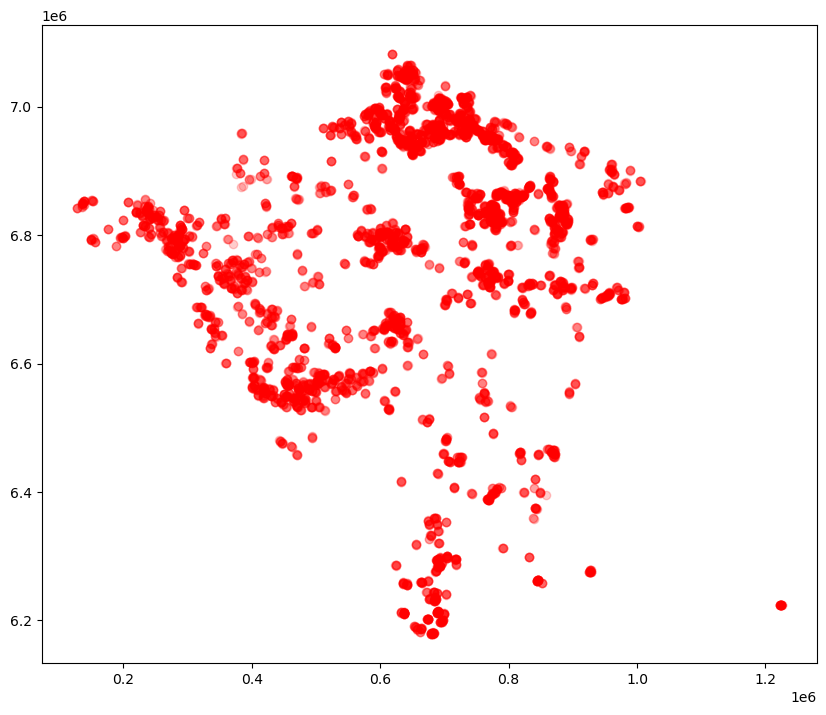

In [29]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

On rajoute désormais le fond de carte grâce au package Cartiflette.

Le génialissime package Cartiflette nous permet de télécharger les données geospatiales qui décrivent le contour de la métropole et de ses régions.

In [19]:
france = get_vectorfile_ign(
    field="metropole",
    level="REGION",
    year=2022)

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS_SHP_WGS84G_PACK_2022-06-21$ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21/file/ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21.7z


Downloading: : 563MiB [06:17, 1.56MiB/s] 


In [20]:
france = france[0:13] #On retire les outre-mers de la carte
france.head()

,ID,NOM_M,NOM,INSEE_REG,geometry
0,REGION_FXX_0000000000001,ILE-DE-FRANCE,Île-de-France,11,"POLYGON ((2.85612 49.07009, 2.85616 49.07011, ..."
1,REGION_FXX_0000000000002,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,"POLYGON ((1.70924 48.57802, 1.70934 48.57801, ..."
2,REGION_FXX_0000000000003,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,"POLYGON ((5.40561 47.64813, 5.40490 47.64851, ..."
3,REGION_FXX_0000000000004,NORMANDIE,Normandie,28,"MULTIPOLYGON (((-1.51486 48.66017, -1.51483 48..."
4,REGION_FXX_0000000000005,HAUTS-DE-FRANCE,Hauts-de-France,32,"POLYGON ((2.80921 49.09753, 2.80762 49.09682, ..."


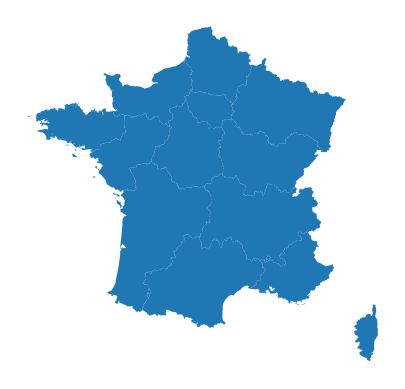

In [21]:
ax = france.plot()
ax.set_axis_off()

Enfin, nous ajoutons les éoliennes sur notre carte de France.

<AxesSubplot:>

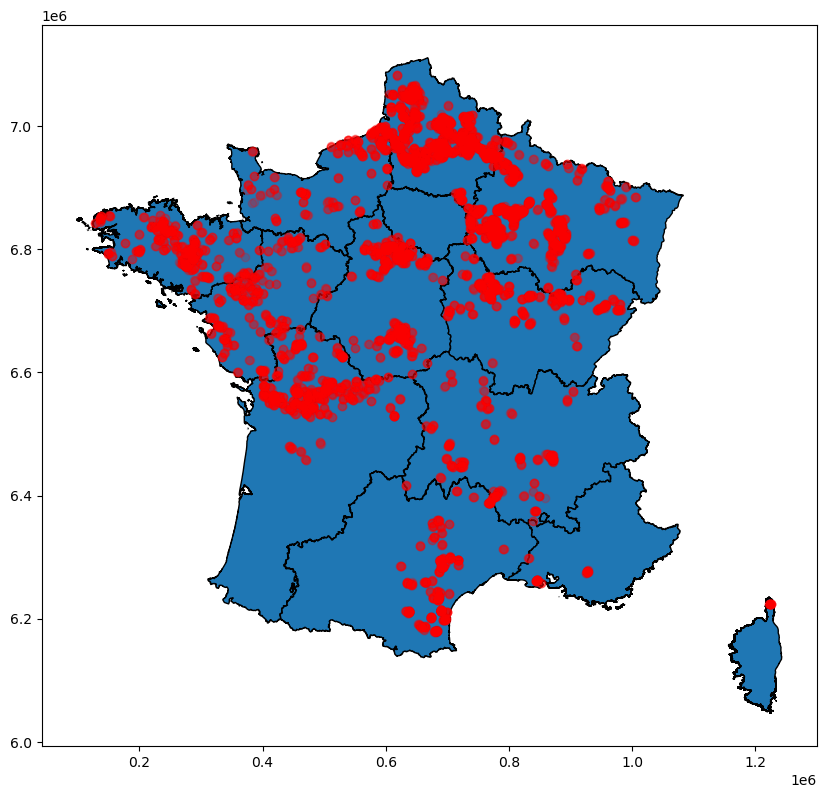

In [22]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")

### **c) Prise en compte de l'évolution du parc éolien dans le temps**

Nos données contiennent la date de mise en service de chaque éolienne. Cela nous permet d'aller plus loin que la simple description spatiale du parc éolien à un instant "t". Nous pouvons décrire l'évolution du parc éolien dans le temps.

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Dans un premier temps, nous affichons les 3152 éoliennes pour lesquelles nous ne connaissons pas leur date de mise en service. Comme nous l'avons dit, ces dernières représentent 42% du parc éolien. 

NameError: name 'france' is not defined

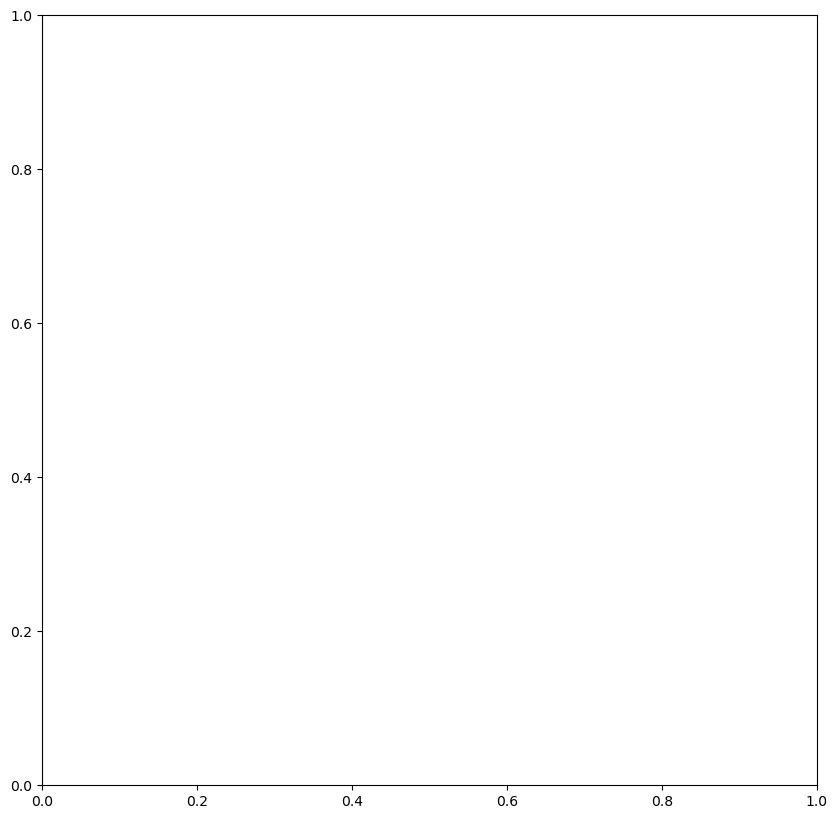

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

Pour celles dont nous connaissons la date, nous affichons l'évolution du parc d'éolienne en fonction du temps.

In [24]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))


from ipywidgets import interact

def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)   
    
interact(signal_plot,
            annee=periode)

interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>

En affichant celle dont on ne connait pas la date de mise en service en vert on obtient ce graphique :

In [25]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'green', alpha = 0.2, zorder=2)  
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)  

interact(signal_plot,
            annee=periode)

interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>

## 2) Modélisation
### a) Modèle linéaire simple

Nous commencerons la modélisation pour une prédiction « naïve » de la production électrique avec un modèle de régression linéaire simple.

### b) Machine learning

Nous utilisons ensuite des modèles de machine learning plus performants pour d’avoir des prédictions plus précises. Nous pourrons comparer les résultats des deux modèles afin d’illustrer les faiblesses du modèle linéaire simple.